# Optimal Execution

### Mid-price model: Path-dependent volatility with mean-reverting drift

### Execution model: Signature Speeds

### Path Dependent Simulator

We will create a simulator that has similar characteristics to that of asset prices, we want to exhibit

- path dependent drift/volatility
- mean-reversion in the drift (temporal alpha)
- skew-like dependence between drift and volatility
- fat tails in returns

We set up the SDE is follows
\begin{align*}
dX_t = \mu_t dt + \sigma_t dW_t
\end{align*}

where
- $\mu_t = f(X_{0,t}) = - \theta \mathrm{ewm}(dW_{0,t})$
- $\sigma_t = \sigma(\mu_t) = \mathrm{skew}(\mu_t)$.

We can see that the drift process is negatively proportional to the exponentially weighted moving average of the driving Brownian motion. This means that the process is mean-reverting and will have decaying negative autocorrelation. This is what we want!

For the volatility process $\sigma_t$, this is essentially going to be the square root of a quartic function of the drift $\mu$. Why? Since this generates the skew relationship and a stochastic volatility. What does this lead to? This is able to create fatter tails in return distribution (which we see empirically) as well as a slow decaying autocorrelation of absolute returns, this essentially means that higher period of volatility will be slow to decay. 

All of these are stylised facts that we observe in practice and are path-dependent. 



In [1]:
import notebook_base

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data.pd_vol import PDVol
from optimal_execution.sig_execution import SigExecution
import optimal_execution.utils

(CVXPY) May 25 02:37:09 PM: Encountered unexpected exception importing solver SCS:
ImportError('libmkl_rt.so.2: cannot open shared object file: No such file or directory')


### Create paths with P-D Vol

In [72]:
execution_params = {
    "N": 2,
    "q0": 1.,
    "Lambda": 1e-3,
    "k": 0,
    "alpha": 10.,
    "phi": 0.,
}

process_params = {
    "sigma":0.04,
    "theta":0.005*200,
    "OU_theta":0.005*200,
    "alpha":0.15,
    "beta":1.,
    "skew_scale":1,
    "n":200,
}

In [73]:
process = PDVol(**process_params)
paths, ES = process.build(n_paths=50000, order= 2 * (execution_params["N"] + 1) + 1)

Building paths:   0%|          | 0/50000 [00:00<?, ?it/s]

Computing signatures:   0%|          | 0/50000 [00:00<?, ?it/s]

#### Autocorrelation of Absolute Returns

- In this example, we want very slow decaying autocorrelation, starting at around ~0.15 and taking 20+ days to decay
- In our example, since we don't have "long" memory incorporated, it decays a bit quicker than we'd like but thats OK

In [74]:
from statsmodels.tsa.stattools import acf

sample = paths[:100]

paths_data = np.abs(np.diff(paths[:,:,1],axis=1))
n_lags = 20

# Calculate the autocorrelation function for each path
acf_values = np.zeros((paths_data.shape[0], n_lags+1))
for i in range(paths_data.shape[0]):
    acf_values[i,:] = acf(paths_data[i,:], nlags=n_lags, fft=False)

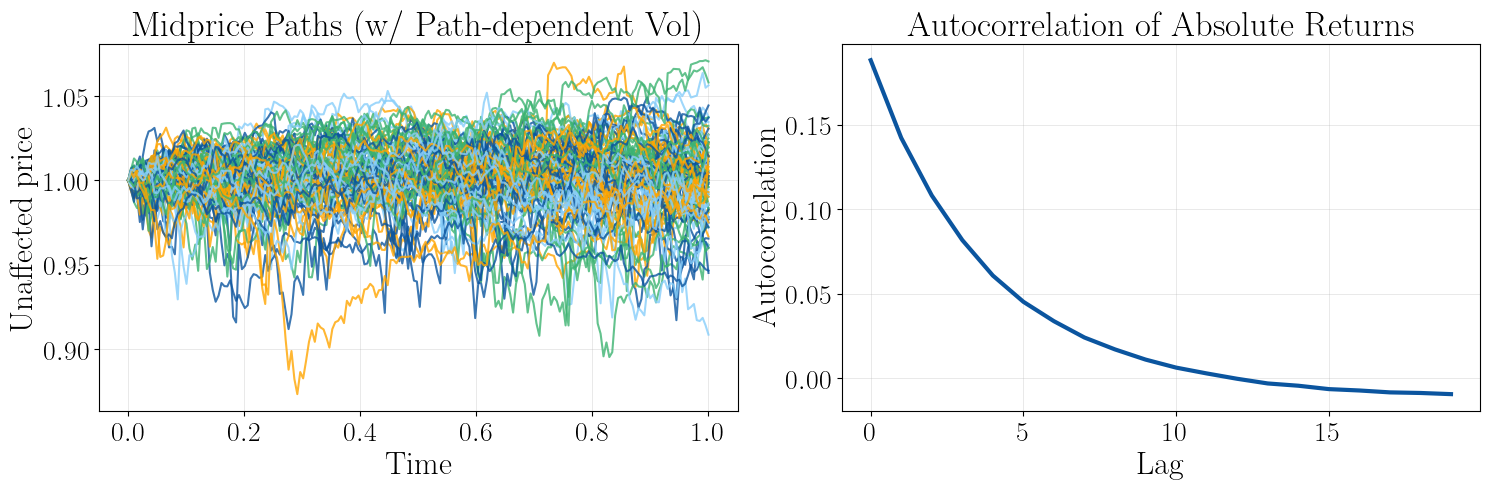

In [75]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(*sample.T, alpha=0.8)
ax[0].set_title(f'Midprice Paths (w/ Path-dependent Vol)', fontsize=25)
ax[0].set_ylabel("Unaffected price")
ax[0].set_xlabel("Time")

# Plot the autocorrelation function for each path
ax[1].plot(acf_values.mean(axis=0)[1:], lw=3)
ax[1].set_title(f'Autocorrelation of Absolute Returns', fontsize=25)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('Autocorrelation')

for i in range(2):
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()

## Fit the linear functional $\ell$

1. Initialise SigExecution class
2. Fit (we see that this is very fast)

In [102]:
SE = SigExecution(ES, **execution_params);

In [103]:
SE.fit()
l = SE.l.value

  0%|          | 0/7 [00:00<?, ?it/s]

## Analysis

In [104]:
speeds, inventory, wealths = SE.get_analytics(sample, phi=0)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

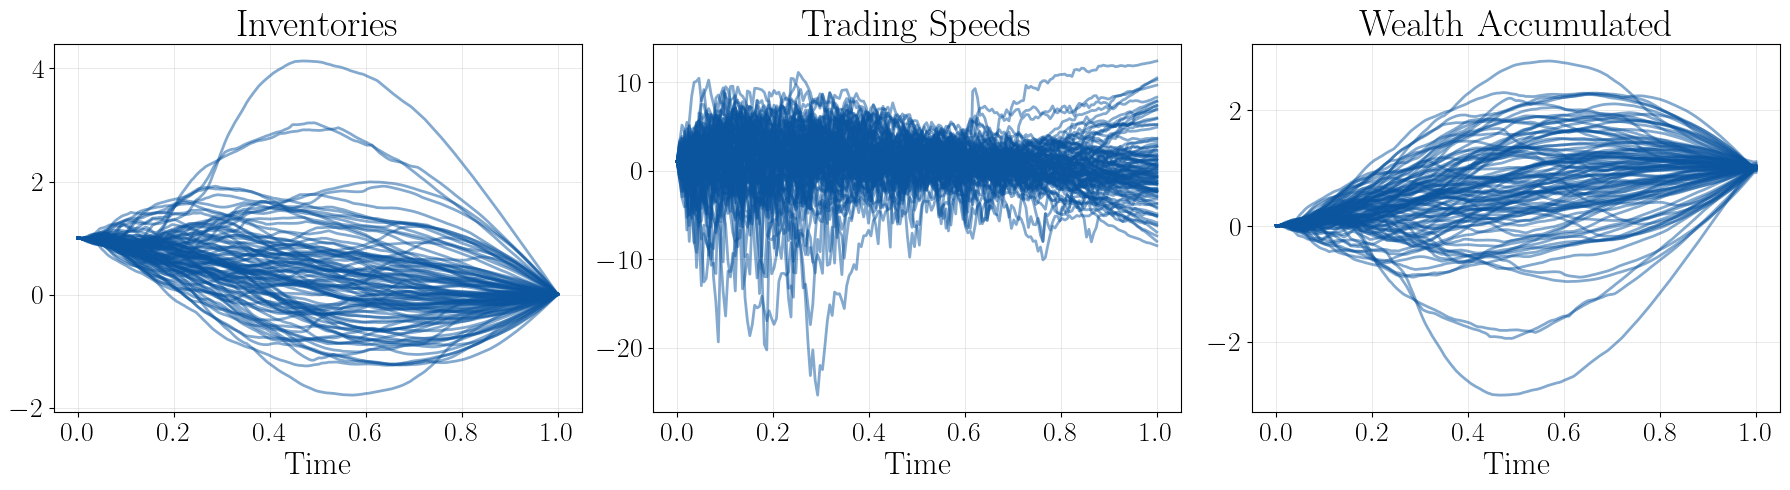

In [105]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

for Q in inventory:    
    ax[0].plot(np.linspace(0, 1, len(Q)), Q, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[0].set_title("Inventories", fontsize=27)

for theta in speeds:    
    ax[1].plot(np.linspace(0, 1, len(theta)), theta, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[1].set_title("Trading Speeds", fontsize=27)

for w in wealths:    
    ax[2].plot(np.linspace(0, 1, len(w)), w, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[2].set_title("Wealth Accumulated", fontsize=27)

for i in range(3):
    ax[i].set_xlabel("Time", fontsize=14)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()


# Changing $\phi$

Here we explore the effect of changing the "urgency term" $\phi$. As $\phi$ is increased, the inventory will decay faster as holding inventory for long periods is penalised. We will solve the optimal execution problem with signatures for different values of $\phi$.

In [80]:
phis = [0, 0.001, 0.005, 0.01]
inventories_phi = []
speeds_phi = []
pnls_phi = []
for phi in phis:
    l = SE.fit(phi)
    speeds, inventories, pnls = SE.get_analytics(paths[:1000])
    
    inventories_phi.append(inventories)
    speeds_phi.append(speeds)
    pnls_phi.append(pnls)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

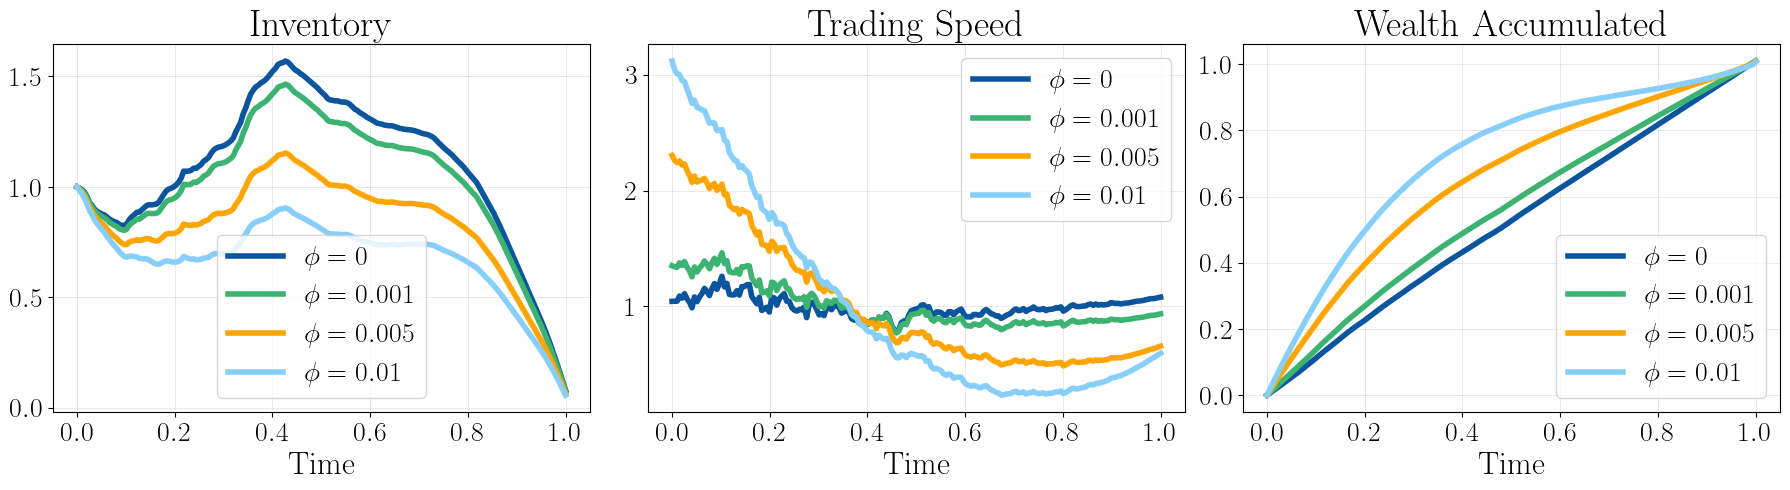

In [95]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

for inventory, phi in zip(inventories_phi, phis):
    for Q in inventory[:1]:
        Q = Q[:-2]
        ax[0].plot(np.linspace(0, 1, len(Q)), Q, alpha=1., label=r"$\phi={}$".format(phi), lw=4)
ax[0].set_title("Inventory", fontsize=27)

for speed, phi in zip(speeds_phi, phis):
    theta = np.stack(speed, axis=-1).mean(axis=1)
    theta = theta[:-2]
    ax[1].plot(np.linspace(0, 1, len(theta)), theta, alpha=1., label=r"$\phi={}$".format(phi), lw=4)
ax[1].set_title("Trading Speed", fontsize=27)

for pnl, phi in zip(pnls_phi, phis):
    wealth = np.stack(pnl, axis=-1).mean(axis=1)
    wealth = wealth
    ax[2].plot(np.linspace(0, 1, len(wealth)), wealth, alpha=1., label=r"$\phi={}$".format(phi), lw=4)
ax[2].set_title("Wealth Accumulated", fontsize=27)

for i in range(3):
    ax[i].set_xlabel("Time", fontsize=14)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)

fig.tight_layout()


### Optimal Trading with $Q_0 = 0$

In [108]:
trading_params = {
    "N": 2,
    "q0": 0.,
    "Lambda": 1e-3,
    "k": 0,
    "alpha": 10.,
    "phi": 0.,
}

In [109]:
SE = SigExecution(ES, **trading_params);
SE.fit()
l = SE.l.value

  0%|          | 0/7 [00:00<?, ?it/s]

In [110]:
## Analysis
speeds, inventories, wealths = SE.get_analytics(sample, phi=0)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

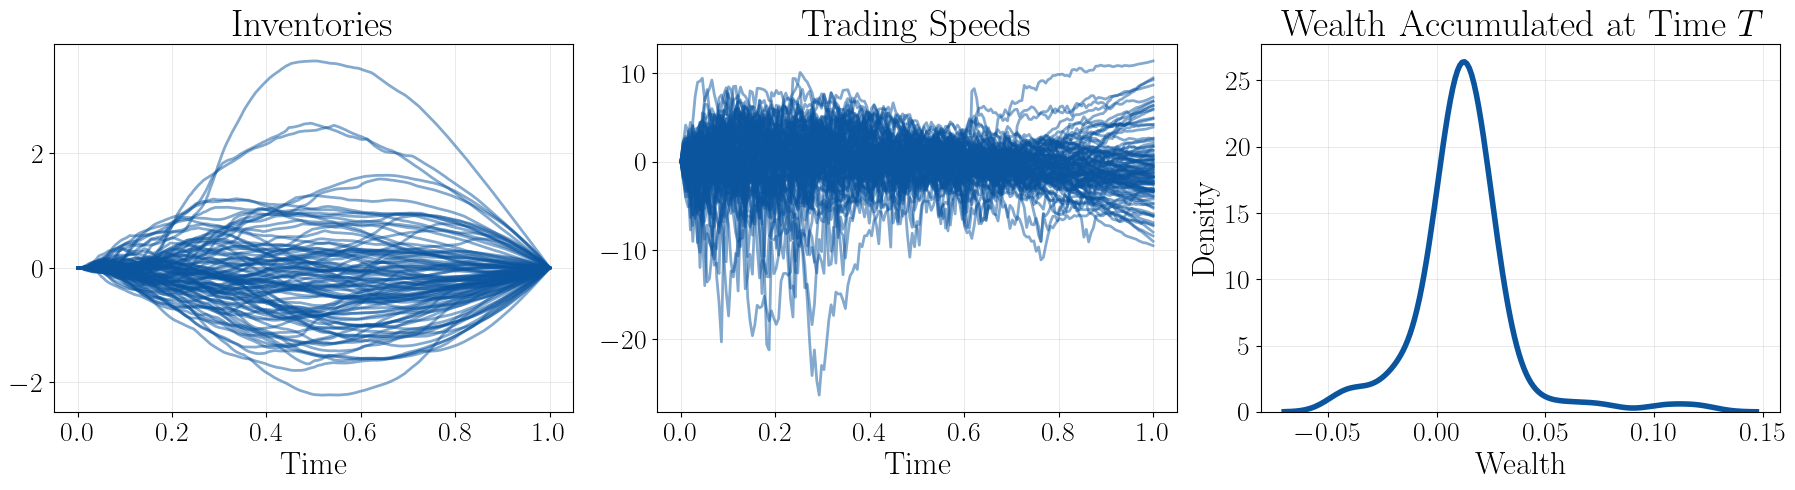

In [115]:
fig, ax = plt.subplots(1,3,figsize=(18,5))

for Q in inventories:    
    ax[0].plot(np.linspace(0, 1, len(Q)), Q, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[0].set_title("Inventories", fontsize=27)

for theta in speeds:    
    ax[1].plot(np.linspace(0, 1, len(theta)), theta, alpha=0.5, lw=2, color=sns.color_palette("Blues")[5])
ax[1].set_title("Trading Speeds", fontsize=27)

sns.kdeplot(np.stack(wealths)[:,-1], lw=4, color=sns.color_palette("Blues")[5], ax = ax[2])
ax[2].set_title(f"Wealth Accumulated at Time $T$", fontsize=27)

for i in range(3):
    ax[i].set_xlabel("Time", fontsize=14)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)
ax[2].set_xlabel("Wealth", fontsize=23)

fig.tight_layout()